In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import pickle
import csv
import implicit
import itertools
import copy
plt.style.use('ggplot')

In [32]:
df = pd.read_csv('book_ratings_implicit.csv')
df.head()

,user_id,title,isbn
0,212142,the house at pooh corner,440437954
1,138777,the house at pooh corner,440437954
2,144997,the house at pooh corner,440437954
3,76626,the house at pooh corner,440437954
4,171118,the house at pooh corner,440437954


In [33]:
n_users = df.user_id.unique().shape[0]
n_items = df.isbn.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of books: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(df.shape[0]) / float(n_users*n_items) * 100))

Number of users: 10717
Number of books: 4888
Sparsity: 0.174%


In [34]:
# Create mappings
isbn_to_idx = {}
idx_to_isbn = {}
for (idx, isbn) in enumerate(df.isbn.unique().tolist()):
    isbn_to_idx[isbn] = idx
    idx_to_isbn[idx] = isbn
    
user_id_to_idx = {}
idx_to_user_id = {}
for (idx, user_id) in enumerate(df.user_id.unique().tolist()):
    user_id_to_idx[user_id] = idx
    idx_to_user_id[idx] = user_id

In [35]:
def map_ids(row, mapper):
    return mapper[row]

In [36]:
# Create sparse matrix
I = df.user_id.apply(map_ids, args=[user_id_to_idx]).as_matrix()
J = df.isbn.apply(map_ids, args=[isbn_to_idx]).as_matrix()
V = np.ones(I.shape[0])
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

/Users/hhn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/hhn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
# Split train/test
def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    train = ratings.copy().tocoo()
    test = sparse.lil_matrix(train.shape)
    
    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0], 
                replace=False,
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*split_count, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    train = train.tolil()

    for user in user_index:
        test_ratings = np.random.choice(ratings.getrow(user).indices, 
                                        size=split_count, 
                                        replace=True)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
   
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

In [38]:
train, test, user_index = train_test_split(likes, 5, fraction=0.2)

In [39]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()

In [40]:
print(repr(eval_train))
print(repr(test))

<10717x4888 sparse matrix of type '<class 'numpy.float64'>'
	with 44777 stored elements in Compressed Sparse Row format>
<10717x4888 sparse matrix of type '<class 'numpy.float64'>'
	with 9535 stored elements in Compressed Sparse Row format>


In [87]:
from lightfm import LightFM
model = LightFM(loss='warp')
%time model.fit(eval_train, epochs=50, num_threads=2)

CPU times: user 1.72 s, sys: 7.61 ms, total: 1.72 s
Wall time: 1.54 s


In [88]:
from lightfm.evaluation import precision_at_k
print("Train precision: %.2f" % precision_at_k(model,eval_train, k=5).mean())
print("Test precision: %.2f" % precision_at_k(model, test, k=5).mean())

Train precision: 0.17
Test precision: 0.02


In [89]:
from lightfm.evaluation import recall_at_k
print("Train recall: %.2f" % recall_at_k(model,eval_train, k=5).mean())
print("Test recall: %.2f" % recall_at_k(model, test, k=5).mean())

Train recall: 0.06
Test recall: 0.02


In [90]:
from lightfm.evaluation import auc_score
print("Train auc: %.2f" % auc_score(model,eval_train).mean())
print("Test auc: %.2f" % auc_score(model,test).mean())

Train auc: 0.95
Test auc: 0.80


In [91]:
def sample_recommendation(model, df, user_ids):


    n_users, n_items = eval_train.shape

    for user_id in user_ids:
        known_positives = df['title'][eval_train.tocsr()[user_id].indices]

        scores = model.predict(user_id, np.arange(n_items))
        top_items = df['title'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")

        for x in known_positives[:5]:
            print("        %s" % x)

        print("     Recommended:")

        for x in top_items[:5]:
            print("        %s" % x)

sample_recommendation(model, df, [3, 100,499])

User 3
     Known positives:
        the house at pooh corner
        big stone gap
        cry, the beloved country
        brave new world
        brave new world
     Recommended:
        the red tent
        the no. 1 ladies' detective agency
        the red tent
        lucky
        i don't know how she does it
User 100
     Known positives:
        winnie the pooh
        the frog king
        the stranger
        the no. 1 ladies' detective agency
        lucky
     Recommended:
        big cherry holler
        don't let's go to the dogs tonight
        don't let's go to the dogs tonight
        murder on the orient express
        lucky
User 499
     Known positives:
        paris to the moon
        cry, the beloved country
        the lovely bones
        the color purple
        the joy luck club
     Recommended:
        the color purple
        the color purple
        the color purple
        the color purple
        the color purple


In [100]:
warp_model = LightFM(no_components=194,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=0.0003,
                    item_alpha=0.0003)

In [101]:
warp_auc = []
for epoch in range(1,50):
    start = time.time()
    warp_model.fit_partial(eval_train, epochs=1)
    warp_auc.append(auc_score(warp_model, test,train_interactions=eval_train).mean())


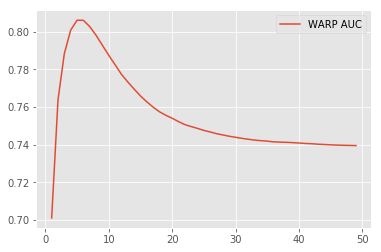

In [102]:
x = np.arange(1,50)
plt.plot(x, np.array(warp_auc))
plt.legend(['WARP AUC'], loc='upper right')
plt.show()